In [5]:
import cv2
import numpy as np

# Load the image
image_path = 'the_berry_farms_sunflower_field.jpeg'
im = cv2.imread(image_path, cv2.IMREAD_REDUCED_COLOR_4)
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Define the range of sigma values
sigma_values = np.linspace(1, 10, 20)  # You can adjust the range as needed

# Initialize variables to store the detected circles and their parameters
detected_circles = []

# Loop through different sigma values
for sigma in sigma_values:
    # Apply Gaussian blur with the current sigma value
    blurred = cv2.GaussianBlur(gray, (0, 0), sigma)
    
    # Compute the Laplacian of Gaussian (LoG)
    log = cv2.Laplacian(blurred, cv2.CV_64F)
    
    # Apply a threshold to the LoG output to detect blob-like structures
    threshold = 0.03  # Adjust the threshold as needed
    blob_mask = (log > threshold)
    
    # Find contours of blob-like structures
    contours, _ = cv2.findContours(np.uint8(blob_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter and draw circles based on the contours
    for contour in contours:
        # Calculate the center and radius of the circle
        ((x, y), radius) = cv2.minEnclosingCircle(contour)
        detected_circles.append((int(x), int(y), int(radius)))

# Draw the detected circles on the image
output_image = im.copy()
for x, y, radius in detected_circles:
    cv2.circle(output_image, (x, y), radius, (0, 255, 0), 2)

# Display or save the output image
cv2.imshow("Detected Circles", output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


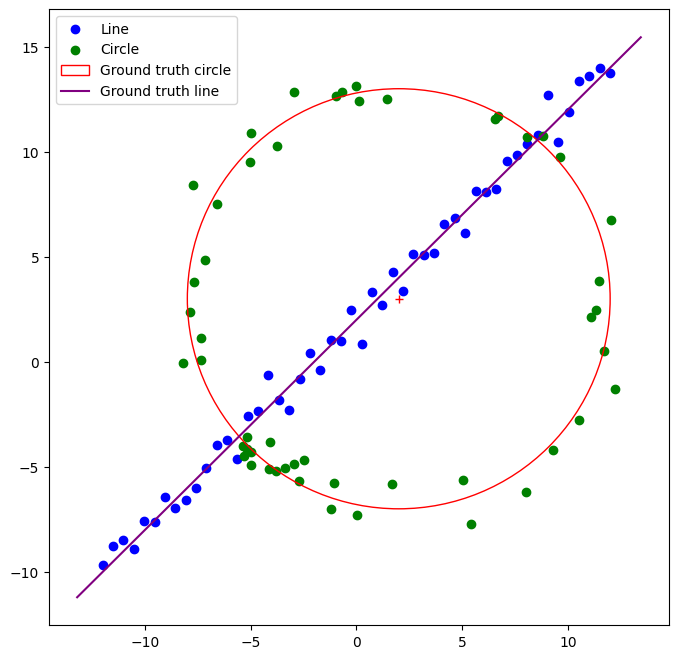

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.136616729484493
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 41.22396012862862
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109.58914742700813
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 43.599518814841986
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 112.65908641673448
            Iterations: 5
            Function evaluations: 2

TypeError: list indices must be integers or slices, not tuple

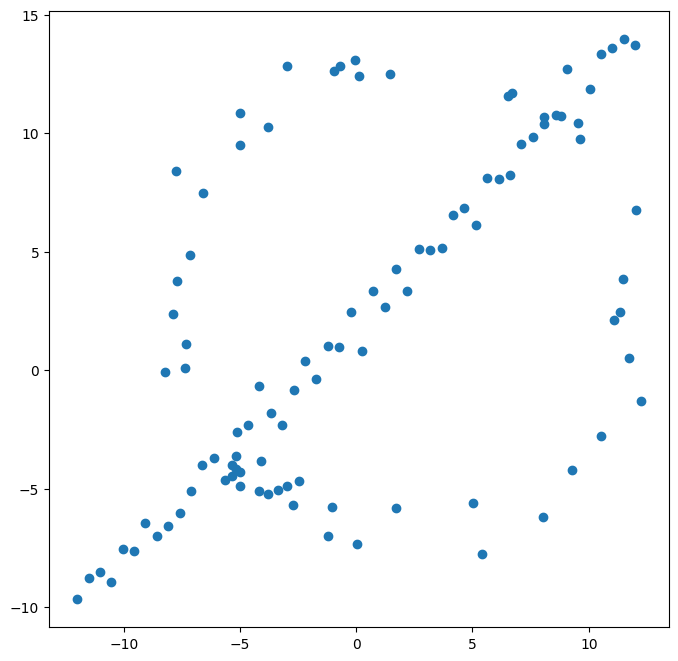

In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import math
from scipy import optimize
import random
from matplotlib.patches import Circle

# Code 2:

# Constants
NUM_POINTS = 100
HALF_NUM_POINTS = NUM_POINTS // 2
CIRCLE_RADIUS = 10
CIRCLE_CENTER_X, CIRCLE_CENTER_Y = 2, 3
NOISE_SCALE = CIRCLE_RADIUS / 16

# Generate points on a circle and a line
circle_angles = np.random.uniform(0, 2 * np.pi, HALF_NUM_POINTS)
circle_noise = NOISE_SCALE * np.random.randn(HALF_NUM_POINTS)
circle_x = CIRCLE_CENTER_X + (CIRCLE_RADIUS + circle_noise) * np.cos(circle_angles)
circle_y = CIRCLE_CENTER_Y + (CIRCLE_RADIUS + circle_noise) * np.sin(circle_angles)
circle_points = np.hstack((circle_x.reshape(HALF_NUM_POINTS, 1), circle_y.reshape(HALF_NUM_POINTS, 1)))

line_slope = 1.0
line_intercept = 2
line_x = np.linspace(-12, 12, HALF_NUM_POINTS)
line_y = line_slope * line_x + line_intercept + NOISE_SCALE * np.random.randn(HALF_NUM_POINTS)
line_points = np.hstack((line_x.reshape(HALF_NUM_POINTS, 1), line_y.reshape(HALF_NUM_POINTS, 1)))

# Combine circle and line points
all_points = np.vstack((circle_points, line_points))

# Create a figure and plot the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(line_points[:, 0], line_points[:, 1], label='Line', color='blue')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle', color='green')

ground_truth_circle = plt.Circle((CIRCLE_CENTER_X, CIRCLE_CENTER_Y), CIRCLE_RADIUS, color='red', fill=False, label='Ground truth circle')
ax.add_patch(ground_truth_circle)
ax.plot(CIRCLE_CENTER_X, CIRCLE_CENTER_Y, '+', color='red')

x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='purple', label='Ground truth line')

plt.legend()
plt.show()

# Code 3:

# Dataset
num_samples = all_points.shape[0]
data = all_points

def calculate_distance(x1, y1, x2, y2):
    distance_magnitude = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    a_val = (x2 - x1) / distance_magnitude
    b_val = (y2 - y1) / distance_magnitude

    d_val = a_val * x1 + b_val * y1

    return a_val, b_val, d_val

def calc_tls(x, indices):
    a_val = x[0]
    b_val = x[1]
    d_val = x[2]

    return np.sum(np.square(a_val * data[indices, 0] + b_val * data[indices, 1] - d_val))

def g_constraint(x):
    return x[0] ** 2 + x[1] ** 2 - 1

def parallel_constraint(x):
    # Ensure that the RANSAC line is nearly parallel to the ground truth line
    # The constraint enforces that the direction (a, b) is close to the ground truth direction
    parallel_direction = np.array([line_slope, -1])  # Direction of the ground truth line
    direction = np.array([x[0], x[1]])  # Direction of the RANSAC line
    return np.dot(parallel_direction, direction)

constraints = ({'type': 'eq', 'fun': g_constraint}, {'type': 'eq', 'fun': parallel_constraint})

def best_fit_line(X, x_params, threshold):
    a_val = x_params[0]
    b_val = x_params[1]
    d_val = x_params[2]

    errors = np.absolute(a_val * X[:, 0] + b_val * X[:, 1] - d_val)

    return errors < threshold

threshold_value = 1.0
num_outliers = 0.5 * num_samples
max_iterations = 100
iteration_count = 0
best_line_model = []
best_error = np.inf
best_sample_line = []
best_inlier_line = []

while iteration_count < max_iterations:
    random_indices = np.random.randint(0, num_samples, 2)
    initial_params = np.array([1, 1, 0])
    result = minimize(fun=calc_tls, args=random_indices, x0=initial_params, tol=1e-6, constraints=constraints, options={'disp': True})
    inlier_mask = best_fit_line(data, result.x, threshold_value)

    if inlier_mask.sum() > num_outliers:
        initial_params = result.x
        result = minimize(fun=calc_tls, args=inlier_mask, x0=initial_params, tol=1e-6, constraints=constraints, options={'disp': True})
        if result.fun < best_error:
            best_error = result.fun
            best_line_model = result.x
            best_sample_line = data[random_indices, :]
            best_inlier_line = inlier_mask
            result_with_sample = initial_params
            print("Best line model: ", best_line_model)
            print("Best error: ", best_error)
            print("Best sample: ", best_sample_line)
            print("Best inlier: ", best_inlier_line)
            print("Number of inliers: ", best_inlier_line.sum())
            print("Number of outliers: ", num_samples - best_inlier_line.sum())
            print("Number of iterations: ", iteration_count)
            print("------------------------------------------------------")

    iteration_count += 1

print("The Best Line model obtained: ", best_line_model)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(data[:, 0], data[:, 1], label='All points')
ax.scatter(data[best_inlier_line, 0], data[best_inlier_line, 1], color='yellow', label='Inliers')
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], color='red', label='Best sample')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[1] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line')
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='purple', label='Ground truth line')
plt.legend()
plt.show()

# Code 4:

def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]

    D_value = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux_value = ((x1 ** 2 + y1 ** 2) * (y2 - y3) + (x2 ** 2 + y2 ** 2) * (y3 - y1) + (x3 ** 2 + y3 ** 2) * (y1 - y2)) / D_value
    Uy_value = ((x1 ** 2 + y1 ** 2) * (x3 - x2) + (x2 ** 2 + y2 ** 2) * (x1 - x3) + (x3 ** 2 + y3 ** 2) * (x2 - x1)) / D_value

    radius_value = np.sqrt((x1 - Ux_value) ** 2 + (y1 - Uy_value) ** 2)

    return Ux_value, Uy_value, radius_value

def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]
        circle_x, circle_y, circle_radius = calculate_circle_parameters(sample_points)
        radial_errors = np.abs(np.sqrt((points[:, 0] - circle_x) ** 2 + (points[:, 1] - circle_y) ** 2) - circle_radius)
        inliers = np.where(radial_errors < error_threshold)[0]
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (circle_x, circle_y, circle_radius)

    return best_circle, best_inliers

num_circle_iterations = 1000
circle_error_threshold = 0.85
circle_min_consensus = 40

best_circle_parameters, circle_inliers = fit_circle_ransac(circle_points, num_circle_iterations, circle_error_threshold, circle_min_consensus)

# Code 5:

outliers_indices = np.where(np.logical_not(best_inlier_line))[0]
outliers_data = data[outliers_indices, :]

plt.subplots(figsize=(8, 8))
plt.scatter(outliers_data[:, 0], outliers_data[:, 1], color='red')
plt.show()

# Code 6:

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(all_points[:, 0], all_points[:, 1], label='Noisy Points', color='blue')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle', color='green')

if best_circle_parameters is not None:  # Check if the circle was successfully estimated
    circle_x, circle_y, circle_radius = best_circle_parameters
    fitted_circle = Circle((circle_x, circle_y), circle_radius, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(fitted_circle)
    ax.scatter(circle_points[circle_inliers, 0], circle_points[circle_inliers, 1], color='orange', label='Circle Inliers')
ground_truth_circle = Circle((CIRCLE_CENTER_X, CIRCLE_CENTER_Y), CIRCLE_RADIUS, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(CIRCLE_CENTER_X, CIRCLE_CENTER_Y, '+', color='red')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()

# Code 7

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(all_points[:, 0], all_points[:, 1], label='Noisy Points', color='blue')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle', color='green')
circle_x, circle_y, circle_radius = best_circle_parameters
fitted_circle = Circle((circle_x, circle_y), circle_radius, color='green', fill=False, label='Best Fit Circle')
ax.add_patch(fitted_circle)
ax.scatter(circle_points[circle_inliers, 0], circle_points[circle_inliers, 1], color='red', label='Circle Inliers')
ground_truth_circle = Circle((CIRCLE_CENTER_X, CIRCLE_CENTER_Y), CIRCLE_RADIUS, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(CIRCLE_CENTER_X, CIRCLE_CENTER_Y, '+', color='red')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[1] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line')
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='purple', label='Ground truth line')
plt.legend()
plt.show()


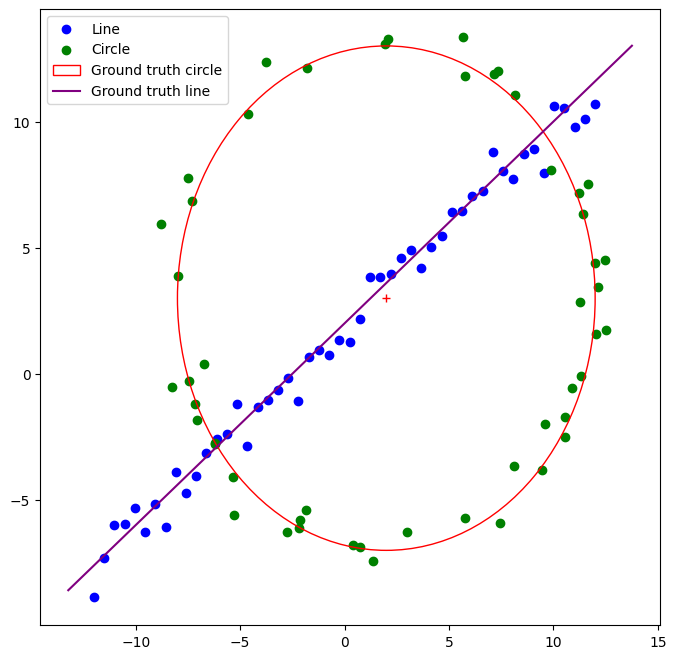

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6548399723551937e-08
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6044101792728492e-12
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.032067240813828e-10
            Iterations: 14
            Function evaluations: 65
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.598174729691784e-12
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0826546200084308e-13
            Iterations: 15
          

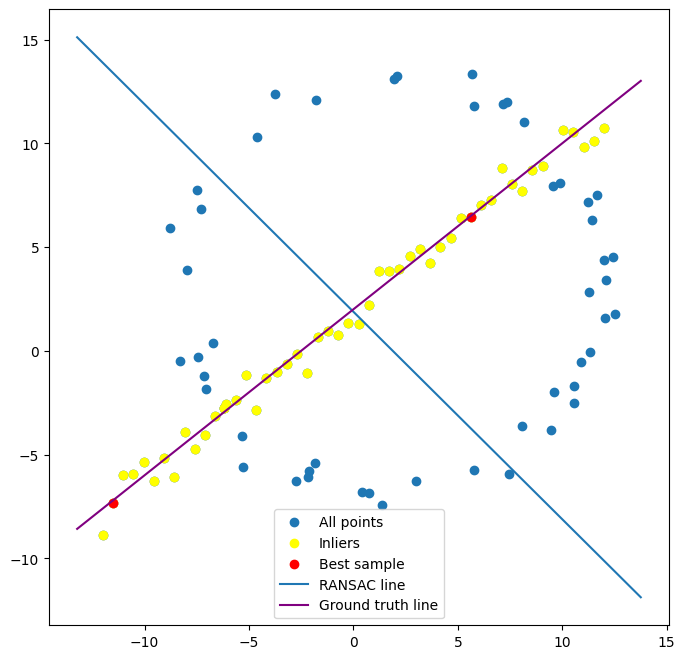

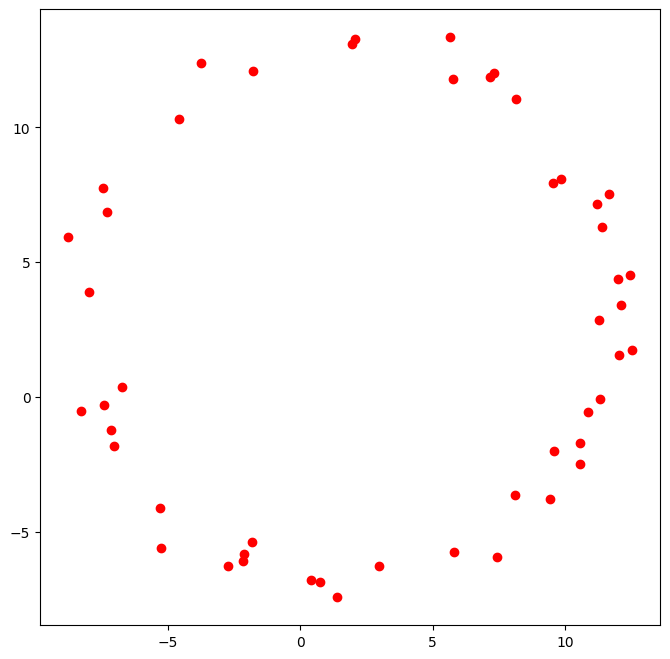

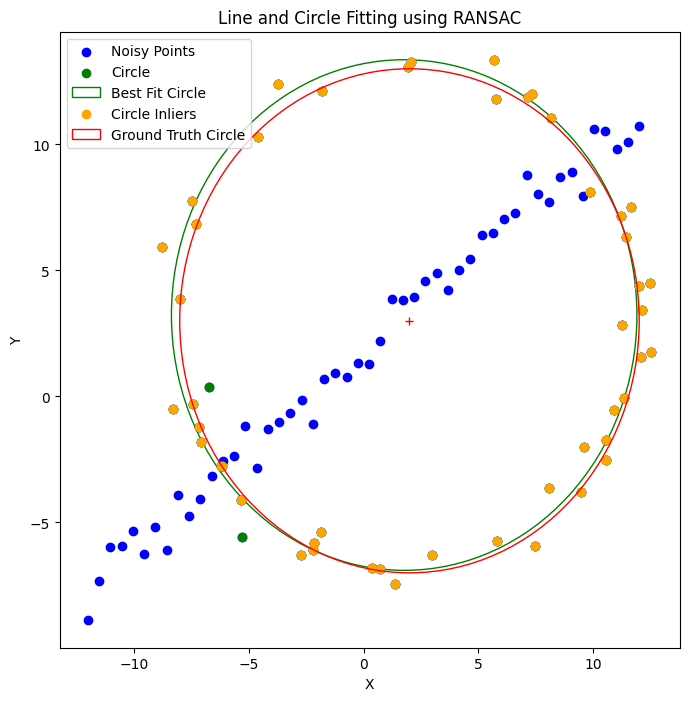

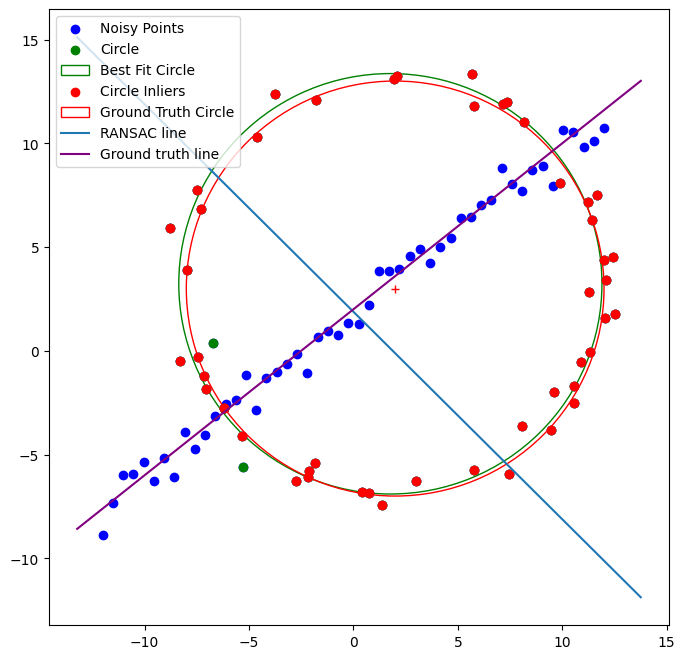

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import math
import random
from matplotlib.patches import Circle

# Code 2:

# Constants
NUM_POINTS = 100
HALF_NUM_POINTS = NUM_POINTS // 2
CIRCLE_RADIUS = 10
CIRCLE_CENTER_X, CIRCLE_CENTER_Y = 2, 3
NOISE_SCALE = CIRCLE_RADIUS / 16

# Generate points on a circle and a line
circle_angles = np.random.uniform(0, 2 * np.pi, HALF_NUM_POINTS)
circle_noise = NOISE_SCALE * np.random.randn(HALF_NUM_POINTS)
circle_x = CIRCLE_CENTER_X + (CIRCLE_RADIUS + circle_noise) * np.cos(circle_angles)
circle_y = CIRCLE_CENTER_Y + (CIRCLE_RADIUS + circle_noise) * np.sin(circle_angles)
circle_points = np.hstack((circle_x.reshape(HALF_NUM_POINTS, 1), circle_y.reshape(HALF_NUM_POINTS, 1)))

# Adjusted slope and intercept for the ground truth line
line_slope = 0.8
line_intercept = 2
line_x = np.linspace(-12, 12, HALF_NUM_POINTS)
line_y = line_slope * line_x + line_intercept + NOISE_SCALE * np.random.randn(HALF_NUM_POINTS)
line_points = np.hstack((line_x.reshape(HALF_NUM_POINTS, 1), line_y.reshape(HALF_NUM_POINTS, 1)))

# Combine circle and line points
all_points = np.vstack((circle_points, line_points))

# Create a figure and plot the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(line_points[:, 0], line_points[:, 1], label='Line', color='blue')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle', color='green')

ground_truth_circle = plt.Circle((CIRCLE_CENTER_X, CIRCLE_CENTER_Y), CIRCLE_RADIUS, color='red', fill=False, label='Ground truth circle')
ax.add_patch(ground_truth_circle)
ax.plot(CIRCLE_CENTER_X, CIRCLE_CENTER_Y, '+', color='red')

x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='purple', label='Ground truth line')

plt.legend()
plt.show()

# Code 3:

# Dataset
num_samples = all_points.shape[0]
data = all_points

def calculate_distance(x1, y1, x2, y2):
    distance_magnitude = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    a_val = (x2 - x1) / distance_magnitude
    b_val = (y2 - y1) / distance_magnitude

    d_val = a_val * x1 + b_val * y1

    return a_val, b_val, d_val

def calc_tls(x, indices):
    a_val = x[0]
    b_val = x[1]
    d_val = x[2]

    return np.sum(np.square(a_val * data[indices, 0] + b_val * data[indices, 1] - d_val))

def g_constraint(x):
    return x[0] ** 2 + x[1] ** 2 - 1

constraints = ({'type': 'eq', 'fun': g_constraint})

def best_fit_line(X, x_params, threshold):
    a_val = x_params[0]
    b_val = x_params[1]
    d_val = x_params[2]

    errors = np.absolute(a_val * X[:, 0] + b_val * X[:, 1] - d_val)

    return errors < threshold

threshold_value = 1.0
num_outliers = 0.5 * num_samples
max_iterations = 100
iteration_count = 0
best_line_model = []
best_error = np.inf
best_sample_line = []
best_inlier_line = []

while iteration_count < max_iterations:
    random_indices = np.random.randint(0, num_samples, 2)
    initial_params = np.array([1, 1, 0])
    result = minimize(fun=calc_tls, args=random_indices, x0=initial_params, tol=1e-6, constraints=constraints, options={'disp': True})
    inlier_mask = best_fit_line(data, result.x, threshold_value)

    if inlier_mask.sum() > num_outliers:
        initial_params = result.x
        result = minimize(fun=calc_tls, args=inlier_mask, x0=initial_params, tol=1e-6, constraints=constraints, options={'disp': True})
        if result.fun < best_error:
            best_error = result.fun
            best_line_model = result.x
            best_sample_line = data[random_indices, :]
            best_inlier_line = inlier_mask
            result_with_sample = initial_params
            print("Best line model: ", best_line_model)
            print("Best error: ", best_error)
            print("Best sample: ", best_sample_line)
            print("Best inlier: ", best_inlier_line)
            print("Number of inliers: ", best_inlier_line.sum())
            print("Number of outliers: ", num_samples - best_inlier_line.sum())
            print("Number of iterations: ", iteration_count)
            print("------------------------------------------------------")

    iteration_count += 1

print("The Best Line model obtained: ", best_line_model)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(data[:, 0], data[:, 1], label='All points')
ax.scatter(data[best_inlier_line, 0], data[best_inlier_line, 1], color='yellow', label='Inliers')
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], color='red', label='Best sample')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[1] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line')
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='purple', label='Ground truth line')
plt.legend()
plt.show()

# Code 4:

def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]

    D_value = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux_value = ((x1 ** 2 + y1 ** 2) * (y2 - y3) + (x2 ** 2 + y2 ** 2) * (y3 - y1) + (x3 ** 2 + y3 ** 2) * (y1 - y2)) / D_value
    Uy_value = ((x1 ** 2 + y1 ** 2) * (x3 - x2) + (x2 ** 2 + y2 ** 2) * (x1 - x3) + (x3 ** 2 + y3 ** 2) * (x2 - x1)) / D_value

    radius_value = np.sqrt((x1 - Ux_value) ** 2 + (y1 - Uy_value) ** 2)

    return Ux_value, Uy_value, radius_value

def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]
        circle_x, circle_y, circle_radius = calculate_circle_parameters(sample_points)
        radial_errors = np.abs(np.sqrt((points[:, 0] - circle_x) ** 2 + (points[:, 1] - circle_y) ** 2) - circle_radius)
        inliers = np.where(radial_errors < error_threshold)[0]
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (circle_x, circle_y, circle_radius)

    return best_circle, best_inliers

num_circle_iterations = 1000
circle_error_threshold = 0.85
circle_min_consensus = 40

best_circle_parameters, circle_inliers = fit_circle_ransac(circle_points, num_circle_iterations, circle_error_threshold, circle_min_consensus)

# Code 5:

outliers_indices = np.where(np.logical_not(best_inlier_line))[0]
outliers_data = data[outliers_indices, :]

plt.subplots(figsize=(8, 8))
plt.scatter(outliers_data[:, 0], outliers_data[:, 1], color='red')
plt.show()

# Code 6:

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(all_points[:, 0], all_points[:, 1], label='Noisy Points', color='blue')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle', color='green')

if best_circle_parameters is not None:  # Check if the circle was successfully estimated
    circle_x, circle_y, circle_radius = best_circle_parameters
    fitted_circle = Circle((circle_x, circle_y), circle_radius, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(fitted_circle)
    ax.scatter(circle_points[circle_inliers, 0], circle_points[circle_inliers, 1], color='orange', label='Circle Inliers')
ground_truth_circle = Circle((CIRCLE_CENTER_X, CIRCLE_CENTER_Y), CIRCLE_RADIUS, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(CIRCLE_CENTER_X, CIRCLE_CENTER_Y, '+', color='red')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()

# Code 7

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(all_points[:, 0], all_points[:, 1], label='Noisy Points', color='blue')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle', color='green')
circle_x, circle_y, circle_radius = best_circle_parameters
fitted_circle = Circle((circle_x, circle_y), circle_radius, color='green', fill=False, label='Best Fit Circle')
ax.add_patch(fitted_circle)
ax.scatter(circle_points[circle_inliers, 0], circle_points[circle_inliers, 1], color='red', label='Circle Inliers')
ground_truth_circle = Circle((CIRCLE_CENTER_X, CIRCLE_CENTER_Y), CIRCLE_RADIUS, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(CIRCLE_CENTER_X, CIRCLE_CENTER_Y, '+', color='red')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[1] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line')
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='purple', label='Ground truth line')
plt.legend()
plt.show()
